## Import Required Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os, datetime
from matplotlib import pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

## Import Dataset and Create DataLoader

In [2]:
train_df = pd.read_csv("../split_datasets/train.csv")
train_df = train_df.drop(columns="id")
train_df = train_df.drop(columns="last_scraped")
train_df = train_df.drop(columns="amenities")

val_df = pd.read_csv("../split_datasets/val.csv")
val_df = val_df.drop(columns="id")
val_df = val_df.drop(columns="last_scraped")
val_df = val_df.drop(columns="amenities")

test_df = pd.read_csv("../split_datasets/test.csv")
test_df = test_df.drop(columns="id")
test_df = test_df.drop(columns="last_scraped")
test_df = test_df.drop(columns="amenities")

In [21]:
#list_of_cols = ['host_is_superhost', 'latitude', 'longitude',
       #'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       #'beds', 'price', 'instant_bookable', 'cancellation_policy',
       #'amenities_count', 'facilities_count', 'house_rules_count']
class airbnb_dataset (Dataset):
    def __init__(self, df, purpose):
        self.df = df#[list_of_cols]
        self.price = self.df["price"]
        self.df = self.df.drop(columns="price")
        self.purpose = purpose
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        # Returns specific sample as a dict
        if torch.is_tensor(index):
            index = index.tolist()
        sample = torch.tensor(np.array(self.df.iloc[index]))
        label = torch.tensor(np.array([self.price.iloc[index]]))
        return {"sample": sample, "label": label}
    
train_ds = airbnb_dataset(train_df, "train")
val_ds = airbnb_dataset(val_df, "val")
test_ds = airbnb_dataset(test_df, "test")

train_loader = DataLoader(train_ds, batch_size=1000, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=1000, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=1000, shuffle=True, num_workers=0)

#### Visualize Data Samples

In [4]:
pd.set_option('display.max_columns', 10)
train_df[list_of_cols].head(5)

,host_is_superhost,latitude,longitude,property_type,room_type,...,instant_bookable,cancellation_policy,amenities_count,facilities_count,house_rules_count
0,0,-0.396491,0.215068,-0.444532,-0.686927,...,0,1.160642,0.293298,1.638226,-0.410572
1,0,-0.841516,0.095963,1.182045,-0.686927,...,0,-1.125796,0.293298,0.791537,-0.410572
2,0,-0.725178,-0.909397,-0.444532,1.329375,...,1,-1.125796,-1.147823,-0.901841,-0.410572
3,0,-0.048882,0.086232,-0.444532,-0.686927,...,0,-0.422277,-1.147823,0.791537,-0.410572
4,0,-0.635052,0.094278,-0.444532,-0.686927,...,0,1.160642,0.293298,-0.055152,1.813424


#### Import Mean and Std File

In [5]:
mean_std = pd.read_csv("../data_processing/mean_std.csv", index_col=0)
mean_std

,mean,std
price,120.097102,68.198942
latitude,43.677492,0.046110
longitude,-79.398326,0.059359
property_type,2.819879,1.844364
room_type,0.340686,0.495957
accommodates,3.053679,1.762132
bathrooms,1.200374,0.459320
bedrooms,1.270343,0.765102
beds,1.625366,0.961066
cancellation_policy,7.400940,5.685699


## Define Model

In [19]:
class airbnb_net (nn.Module):
    def __init__(self):
        super(airbnb_net, self).__init__()
        self.layer1 = nn.Linear(41, 20)
        self.layer2 = nn.Linear(20, 1)
        #self.layer3 = nn.Linear(14*2, 14*2)
        #self.layer4 = nn.Linear(14*2, 14*2)
        #self.layer5 = nn.Linear(14*2, 14*1)
        #self.layer6 = nn.Linear(14*1, 1)
        
        #self.dropout1 = nn.Dropout(p=0.8)
        self.dropout2 = nn.Dropout(p=0.5)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout2(x)
        #x = torch.relu(self.layer2(x))
        #x = self.dropout2(x)
        #x = torch.relu(self.layer3(x))
        #x = self.dropout2(x)
        #x = torch.relu(self.layer4(x))
        #x = self.dropout2(x)
        #x = torch.relu(self.layer5(x))
        return self.layer2(x)

## Training Function

In [22]:
def train(net, train_loader, val_loader, folder, lr, num_epoch):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    print("Starting Training...")
    start_time = time.time()
    epochs, losses = [], []
    epochs2, train_error, val_error, train_acc, val_acc = [], [], [], [[],[],[]], [[],[],[]]
    
    for epoch in range(num_epoch):
        epoch_loss = 0
        epoch_time = time.time()
        batch_loss = 0
        batch_time = time.time()
        for i, data in enumerate(train_loader):
            sample = data["sample"].float()
            label = data["label"].float()
            output = net(sample)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            batch_loss += loss.item()
            epoch_loss += loss.item()
            if i % 10 == 9:
                batch_loss = batch_loss/10
                print("---[ITER %d] loss: %.6f  time: %.3f" % (i+1, batch_loss, time.time()-batch_time))
                batch_loss = 0
                batch_time = time.time()
        epoch_loss /= len(train_loader)
        
        # Record Loss
        epochs.append(epoch)
        losses.append(epoch_loss)
        
        # Record Error, Accuracy 
        if epoch % 10 == 9:
            epochs2.append(epoch)
            avg_train_error, avg_train_acc, avg_val_error, avg_val_acc = get_error(net, train_loader, val_loader, [10, 20, 30])
            train_error.append(avg_train_error)
            val_error.append(avg_val_error)
            for i in range(3):
                train_acc[i].append(avg_train_acc[i])
                val_acc[i].append(avg_val_acc[i])
                
            torch.save({
                    'epoch' : epoch,
                    'model_state_dict' : net.state_dict(),
                    'optimizer_state_dict' : optimizer.state_dict(),
                    'epochs' : epochs,
                    'losses' : losses,
                    'epochs2': epochs2,
                    'train_error': train_error,
                    'train_acc': train_acc,
                    'val_error': val_error,
                    'val_acc' : val_acc,
                    'lr' : lr
                }, folder+"/checkpoint/checkpoint_"+'{:04d}'.format(epoch)+".tar")
        
        print("[EPOCH %d] loss: %.6f  time: %.3f" % (epoch+1, epoch_loss, time.time()-epoch_time))
        
        if epoch % 10 == 9:
            plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last=False)

    print("=========================================")
    print("Training Completed...")
    print("[FINAL] loss: %.6f  time: %.3f" % (epoch_loss, time.time()-start_time))
          
    # plot loss, error, accuracy
    plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last=True)
    
    torch.save({
        'epoch' : epoch,
        'model_state_dict' : net.state_dict(),
        'optimizer_state_dict' : optimizer.state_dict(),
        'epochs' : epochs,
        'losses' : losses,
        'epochs2': epochs2,
        'train_error': train_error,
        'train_acc': train_acc,
        'val_error': val_error,
        'val_acc' : val_acc,
        'lr' : lr
    }, folder+"/final/checkpoint_final.tar")

## Plotting Function

In [8]:
def plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last = False):
    # plot loss curve
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    if last == False:
        plt.savefig(folder+"/lossplot/lossplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/lossplot_final.png", dpi=150)
    plt.show()
    plt.close()
    
    # plot error curve
    plt.title("Training Error Curve")
    plt.plot(epochs2, train_error, label="Train")
    plt.plot(epochs2, val_error, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Absolute Error (in $)")
    plt.legend(loc='best')

    if last == False:
        plt.savefig(folder+"/errorplot/errorplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/errorplot_final.png", dpi=150)
    plt.show()
    plt.close()

    # plot accuracy curve
    plt.title("Training Accuracy Curve")
    for i in range(3):
        plt.plot(epochs2, train_acc[i], label="Train - Thresh: "+str(i*10+10))
        plt.plot(epochs2, val_acc[i], label="Validation - Thresh: "+str(i*10+10))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    
    if last == False:
        plt.savefig(folder+"/accplot/accplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/accplot_final.png", dpi=150)
    
    plt.show()
    plt.close()

    return None

## Error Calculation Function

In [9]:
def get_error(model, train_loader, val_loader, threshold):
    train_samples = 0
    train_error = 0
    train_accuracy = [0 for i in threshold]
    for i, data in enumerate(train_loader):
        sample = data["sample"].float()
        label = data["label"].float()
        output = net(sample)
        error = abs(label-output)*mean_std["std"]["price"]
        for j in range(len(threshold)):
            accurate = error < float(threshold[j])
            train_accuracy[j] += accurate.sum().item()
        train_samples += len(label)
        train_error += error.sum().item()
    avg_train_error = float(train_error)/float(train_samples)
    avg_train_accuracy = [float(a)/float(train_samples) for a in train_accuracy]
    
    val_samples = 0
    val_error = 0
    val_accuracy = [0 for i in threshold]
    for i, data in enumerate(val_loader):
        sample = data["sample"].float()
        label = data["label"].float()
        output = net(sample)
        error = abs(label-output)*mean_std["std"]["price"]
        for j in range(len(threshold)):
            accurate = error < float(threshold[j])
            val_accuracy[j] += accurate.sum().item()
        val_samples += len(label)
        val_error += error.sum().item()
    avg_val_error = float(val_error)/float(val_samples)
    avg_val_accuracy = [float(a)/float(val_samples) for a in val_accuracy]

    return avg_train_error, avg_train_accuracy, avg_val_error, avg_val_accuracy

## Training

Starting Training...
---[ITER 10] loss: 1.232519  time: 3.297
---[ITER 20] loss: 1.203516  time: 3.118
---[ITER 30] loss: 1.138849  time: 3.152
---[ITER 40] loss: 1.126107  time: 3.396
---[ITER 50] loss: 1.135102  time: 3.370
---[ITER 60] loss: 1.095499  time: 3.138
---[ITER 70] loss: 1.112440  time: 3.129
---[ITER 80] loss: 1.051304  time: 3.114
---[ITER 90] loss: 1.062050  time: 3.123
---[ITER 100] loss: 1.067517  time: 3.535
---[ITER 110] loss: 1.047398  time: 2.923
---[ITER 120] loss: 1.032905  time: 3.013
---[ITER 130] loss: 1.003602  time: 3.049
---[ITER 140] loss: 0.996055  time: 3.095
---[ITER 150] loss: 0.943645  time: 3.115
---[ITER 160] loss: 0.970696  time: 4.090
[EPOCH 1] loss: 1.069401  time: 54.662
---[ITER 10] loss: 0.970851  time: 5.001
---[ITER 20] loss: 0.920183  time: 3.374
---[ITER 30] loss: 0.902182  time: 3.030
---[ITER 40] loss: 0.890891  time: 2.907
---[ITER 50] loss: 0.892058  time: 3.353
---[ITER 60] loss: 0.879140  time: 3.064
---[ITER 70] loss: 0.854548  ti

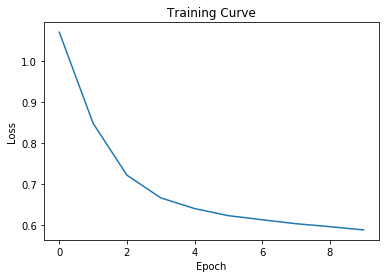

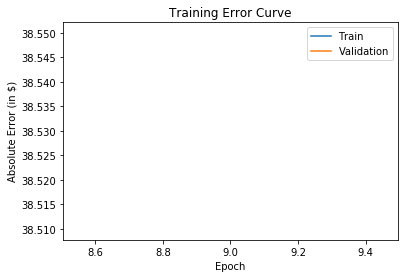

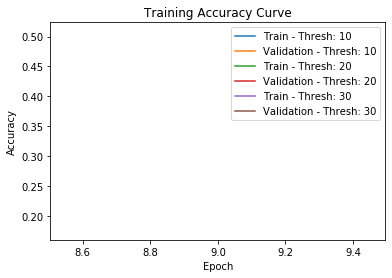

---[ITER 10] loss: 0.575280  time: 3.611
---[ITER 20] loss: 0.585420  time: 4.080
---[ITER 30] loss: 0.590512  time: 4.214
---[ITER 40] loss: 0.564496  time: 4.218
---[ITER 50] loss: 0.587176  time: 4.044
---[ITER 60] loss: 0.582259  time: 4.609
---[ITER 70] loss: 0.601499  time: 5.400
---[ITER 80] loss: 0.579001  time: 5.226
---[ITER 90] loss: 0.593713  time: 3.542
---[ITER 100] loss: 0.568107  time: 3.690
---[ITER 110] loss: 0.582828  time: 3.473
---[ITER 120] loss: 0.593436  time: 3.637
---[ITER 130] loss: 0.587307  time: 3.077
---[ITER 140] loss: 0.566979  time: 3.150
---[ITER 150] loss: 0.589960  time: 4.736
---[ITER 160] loss: 0.573751  time: 3.590
[EPOCH 11] loss: 0.581619  time: 67.197
---[ITER 10] loss: 0.587523  time: 3.828
---[ITER 20] loss: 0.578879  time: 4.930
---[ITER 30] loss: 0.570579  time: 3.308
---[ITER 40] loss: 0.582650  time: 4.615
---[ITER 50] loss: 0.583654  time: 3.570
---[ITER 60] loss: 0.573624  time: 4.932
---[ITER 70] loss: 0.578796  time: 3.364
---[ITER 8

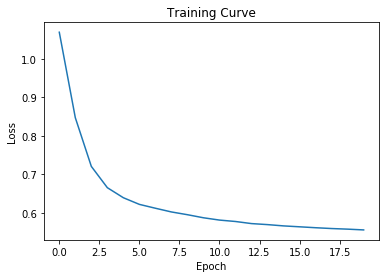

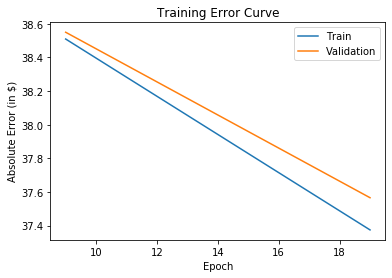

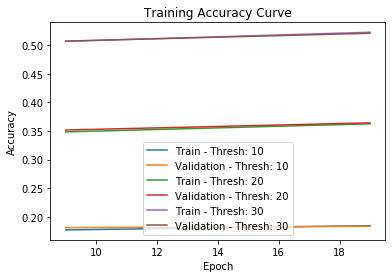

---[ITER 10] loss: 0.541914  time: 3.121
---[ITER 20] loss: 0.567091  time: 3.116
---[ITER 30] loss: 0.545178  time: 3.149
---[ITER 40] loss: 0.549313  time: 3.279
---[ITER 50] loss: 0.558205  time: 3.143
---[ITER 60] loss: 0.574002  time: 3.158
---[ITER 70] loss: 0.553552  time: 3.045
---[ITER 80] loss: 0.564124  time: 2.925
---[ITER 90] loss: 0.563427  time: 3.237
---[ITER 100] loss: 0.550599  time: 3.282
---[ITER 110] loss: 0.564339  time: 3.029
---[ITER 120] loss: 0.530299  time: 3.078
---[ITER 130] loss: 0.553786  time: 3.021
---[ITER 140] loss: 0.550182  time: 2.973
---[ITER 150] loss: 0.552877  time: 2.973
---[ITER 160] loss: 0.557355  time: 2.936
[EPOCH 21] loss: 0.553348  time: 51.935
---[ITER 10] loss: 0.559256  time: 3.197
---[ITER 20] loss: 0.554132  time: 3.209
---[ITER 30] loss: 0.566139  time: 3.610
---[ITER 40] loss: 0.541028  time: 3.288
---[ITER 50] loss: 0.573376  time: 3.155
---[ITER 60] loss: 0.528987  time: 3.452
---[ITER 70] loss: 0.534496  time: 3.214
---[ITER 8

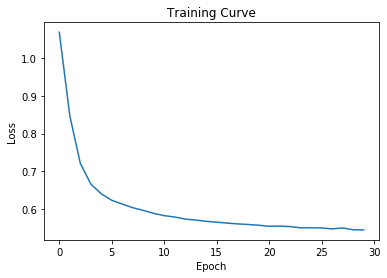

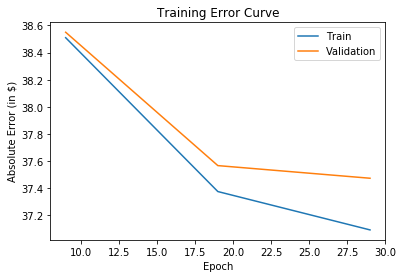

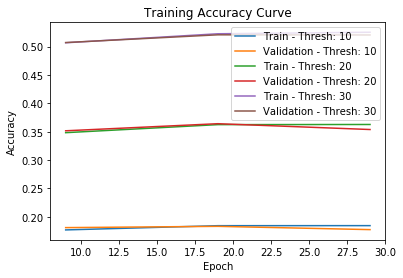

---[ITER 10] loss: 0.536003  time: 3.450
---[ITER 20] loss: 0.544136  time: 3.262
---[ITER 30] loss: 0.531455  time: 2.989
---[ITER 40] loss: 0.545616  time: 2.966
---[ITER 50] loss: 0.551501  time: 3.023
---[ITER 60] loss: 0.540191  time: 3.114
---[ITER 70] loss: 0.551481  time: 3.080
---[ITER 80] loss: 0.558149  time: 3.388
---[ITER 90] loss: 0.554608  time: 3.135
---[ITER 100] loss: 0.551693  time: 3.120
---[ITER 110] loss: 0.543911  time: 3.084
---[ITER 120] loss: 0.534098  time: 3.082
---[ITER 130] loss: 0.535166  time: 3.159
---[ITER 140] loss: 0.546707  time: 3.326
---[ITER 150] loss: 0.529366  time: 3.332
---[ITER 160] loss: 0.571625  time: 3.292
[EPOCH 31] loss: 0.546592  time: 53.385
---[ITER 10] loss: 0.532511  time: 3.230
---[ITER 20] loss: 0.538207  time: 3.236
---[ITER 30] loss: 0.548179  time: 3.287
---[ITER 40] loss: 0.539948  time: 3.372
---[ITER 50] loss: 0.546928  time: 2.985
---[ITER 60] loss: 0.535177  time: 2.911
---[ITER 70] loss: 0.525311  time: 3.034
---[ITER 8

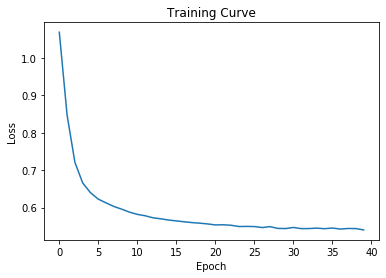

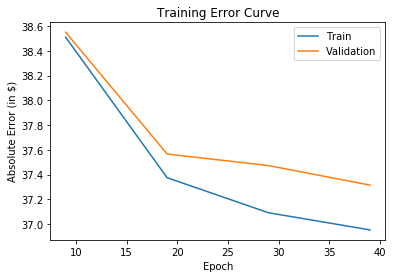

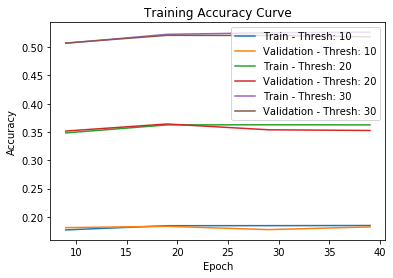

---[ITER 10] loss: 0.565914  time: 3.629
---[ITER 20] loss: 0.547320  time: 4.321
---[ITER 30] loss: 0.550097  time: 3.388
---[ITER 40] loss: 0.537062  time: 3.162
---[ITER 50] loss: 0.543346  time: 3.440
---[ITER 60] loss: 0.571366  time: 2.980
---[ITER 70] loss: 0.535373  time: 3.027
---[ITER 80] loss: 0.544073  time: 3.024
---[ITER 90] loss: 0.539678  time: 4.063
---[ITER 100] loss: 0.541898  time: 3.543
---[ITER 110] loss: 0.524159  time: 3.388
---[ITER 120] loss: 0.542117  time: 3.376
---[ITER 130] loss: 0.553711  time: 3.068
---[ITER 140] loss: 0.526724  time: 3.249
---[ITER 150] loss: 0.534846  time: 2.991
---[ITER 160] loss: 0.525197  time: 3.029
[EPOCH 41] loss: 0.542456  time: 56.132
---[ITER 10] loss: 0.534472  time: 3.065
---[ITER 20] loss: 0.525507  time: 3.149
---[ITER 30] loss: 0.540098  time: 3.267
---[ITER 40] loss: 0.541354  time: 3.341
---[ITER 50] loss: 0.554715  time: 3.308
---[ITER 60] loss: 0.545483  time: 3.171
---[ITER 70] loss: 0.550702  time: 3.345
---[ITER 8

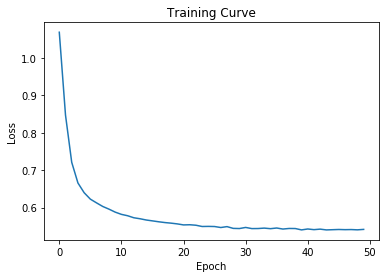

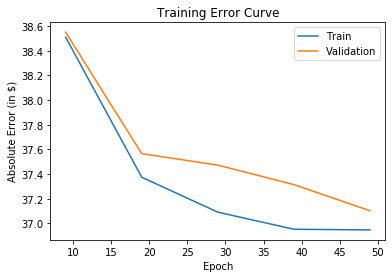

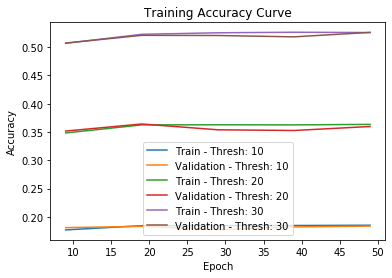

---[ITER 10] loss: 0.528465  time: 5.511
---[ITER 20] loss: 0.526655  time: 6.203
---[ITER 30] loss: 0.531109  time: 6.435
---[ITER 40] loss: 0.502500  time: 5.706
---[ITER 50] loss: 0.537322  time: 5.904
---[ITER 60] loss: 0.548705  time: 5.312
---[ITER 70] loss: 0.535619  time: 5.604
---[ITER 80] loss: 0.523457  time: 5.286
---[ITER 90] loss: 0.546990  time: 6.752
---[ITER 100] loss: 0.554523  time: 7.584
---[ITER 110] loss: 0.564204  time: 6.401
---[ITER 120] loss: 0.525501  time: 5.552
---[ITER 130] loss: 0.553867  time: 5.957
---[ITER 140] loss: 0.546768  time: 9.090
---[ITER 150] loss: 0.565767  time: 5.134
---[ITER 160] loss: 0.550210  time: 4.324
[EPOCH 51] loss: 0.540769  time: 100.287
---[ITER 10] loss: 0.542350  time: 5.035
---[ITER 20] loss: 0.563470  time: 5.256
---[ITER 30] loss: 0.530025  time: 4.476
---[ITER 40] loss: 0.534084  time: 4.797
---[ITER 50] loss: 0.549346  time: 7.835
---[ITER 60] loss: 0.536295  time: 6.684
---[ITER 70] loss: 0.521343  time: 5.757
---[ITER 

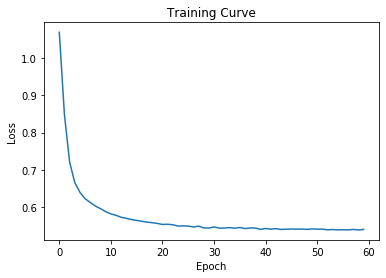

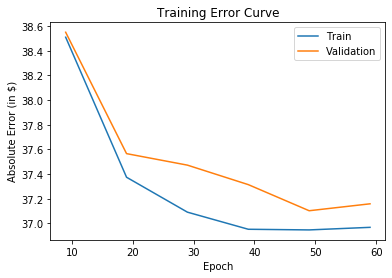

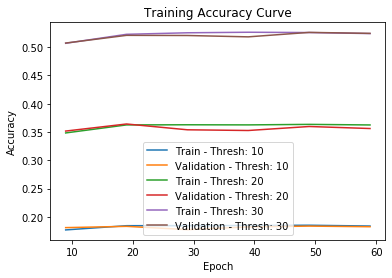

---[ITER 10] loss: 0.555335  time: 6.534
---[ITER 20] loss: 0.529159  time: 6.665
---[ITER 30] loss: 0.528278  time: 8.604
---[ITER 40] loss: 0.547265  time: 7.216
---[ITER 50] loss: 0.539023  time: 7.850
---[ITER 60] loss: 0.532155  time: 6.213
---[ITER 70] loss: 0.523104  time: 7.902
---[ITER 80] loss: 0.531238  time: 6.507
---[ITER 90] loss: 0.562668  time: 7.798
---[ITER 100] loss: 0.541535  time: 5.852
---[ITER 110] loss: 0.534487  time: 5.257
---[ITER 120] loss: 0.533926  time: 5.868
---[ITER 130] loss: 0.526884  time: 6.904
---[ITER 140] loss: 0.561087  time: 5.728
---[ITER 150] loss: 0.549348  time: 6.091
---[ITER 160] loss: 0.529192  time: 6.671
[EPOCH 61] loss: 0.538815  time: 112.547
---[ITER 10] loss: 0.544439  time: 6.174
---[ITER 20] loss: 0.551994  time: 5.602
---[ITER 30] loss: 0.531708  time: 4.698
---[ITER 40] loss: 0.534602  time: 4.976
---[ITER 50] loss: 0.538428  time: 4.846
---[ITER 60] loss: 0.546806  time: 5.168
---[ITER 70] loss: 0.531108  time: 5.003
---[ITER 

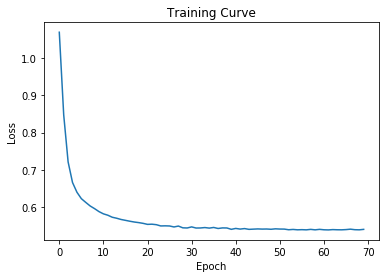

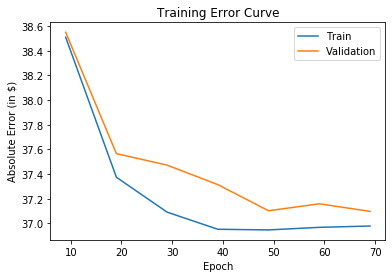

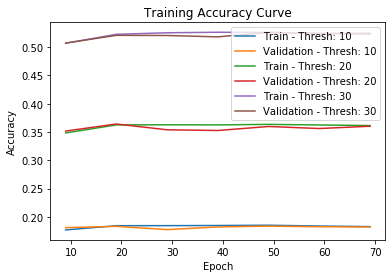

---[ITER 10] loss: 0.567799  time: 3.473
---[ITER 20] loss: 0.534059  time: 3.398
---[ITER 30] loss: 0.535619  time: 3.588
---[ITER 40] loss: 0.530496  time: 3.578
---[ITER 50] loss: 0.551420  time: 4.124
---[ITER 60] loss: 0.543703  time: 3.690
---[ITER 70] loss: 0.529252  time: 3.983
---[ITER 80] loss: 0.529726  time: 3.704
---[ITER 90] loss: 0.527186  time: 3.773
---[ITER 100] loss: 0.530127  time: 3.613
---[ITER 110] loss: 0.529191  time: 3.652
---[ITER 120] loss: 0.534378  time: 3.565
---[ITER 130] loss: 0.545028  time: 3.365
---[ITER 140] loss: 0.558316  time: 4.060
---[ITER 150] loss: 0.533414  time: 6.246
---[ITER 160] loss: 0.556753  time: 4.607
[EPOCH 71] loss: 0.538971  time: 67.172
---[ITER 10] loss: 0.541778  time: 4.614
---[ITER 20] loss: 0.537910  time: 7.655
---[ITER 30] loss: 0.528740  time: 4.352
---[ITER 40] loss: 0.532492  time: 5.225
---[ITER 50] loss: 0.539277  time: 4.307
---[ITER 60] loss: 0.528710  time: 4.918
---[ITER 70] loss: 0.557594  time: 5.190
---[ITER 8

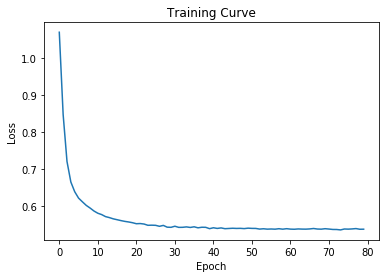

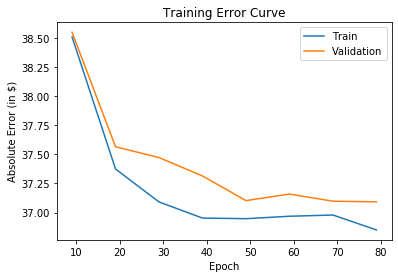

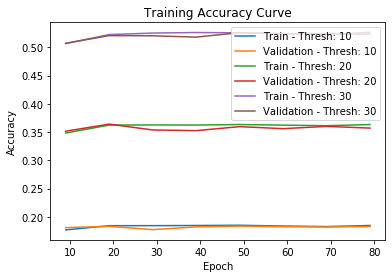

---[ITER 10] loss: 0.542389  time: 3.383
---[ITER 20] loss: 0.525336  time: 3.297
---[ITER 30] loss: 0.552409  time: 3.575
---[ITER 40] loss: 0.546484  time: 3.378
---[ITER 50] loss: 0.558598  time: 3.369
---[ITER 60] loss: 0.526151  time: 3.459
---[ITER 70] loss: 0.560935  time: 3.421
---[ITER 80] loss: 0.543750  time: 3.477
---[ITER 90] loss: 0.543648  time: 3.582
---[ITER 100] loss: 0.547522  time: 3.522
---[ITER 110] loss: 0.520057  time: 3.468
---[ITER 120] loss: 0.516195  time: 3.431
---[ITER 130] loss: 0.527527  time: 3.650
---[ITER 140] loss: 0.535295  time: 3.400
---[ITER 150] loss: 0.533592  time: 3.592
---[ITER 160] loss: 0.545586  time: 3.809
[EPOCH 81] loss: 0.539481  time: 58.434
---[ITER 10] loss: 0.540659  time: 3.435
---[ITER 20] loss: 0.530087  time: 3.412
---[ITER 30] loss: 0.532606  time: 3.234
---[ITER 40] loss: 0.559665  time: 3.607
---[ITER 50] loss: 0.542463  time: 3.327
---[ITER 60] loss: 0.519651  time: 3.394
---[ITER 70] loss: 0.544004  time: 3.370
---[ITER 8

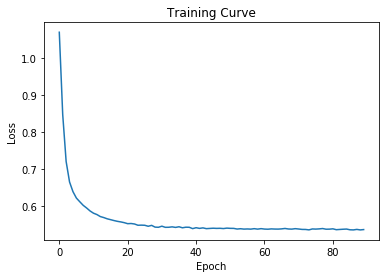

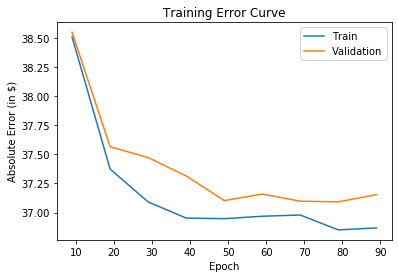

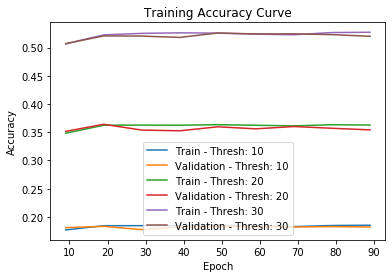

---[ITER 10] loss: 0.538793  time: 4.181
---[ITER 20] loss: 0.521774  time: 4.902
---[ITER 30] loss: 0.536213  time: 4.188
---[ITER 40] loss: 0.548654  time: 3.717
---[ITER 50] loss: 0.540093  time: 3.702
---[ITER 60] loss: 0.529749  time: 3.929
---[ITER 70] loss: 0.527551  time: 3.578
---[ITER 80] loss: 0.534098  time: 3.628
---[ITER 90] loss: 0.543922  time: 3.514
---[ITER 100] loss: 0.530655  time: 3.195
---[ITER 110] loss: 0.571665  time: 3.253
---[ITER 120] loss: 0.539691  time: 4.198
---[ITER 130] loss: 0.537660  time: 3.193
---[ITER 140] loss: 0.532879  time: 3.030
---[ITER 150] loss: 0.545763  time: 4.422
---[ITER 160] loss: 0.543913  time: 3.100
[EPOCH 91] loss: 0.539453  time: 62.069
---[ITER 10] loss: 0.518727  time: 3.066
---[ITER 20] loss: 0.523430  time: 2.999
---[ITER 30] loss: 0.531581  time: 3.036
---[ITER 40] loss: 0.525588  time: 2.967
---[ITER 50] loss: 0.556080  time: 3.087
---[ITER 60] loss: 0.535769  time: 3.365
---[ITER 70] loss: 0.567565  time: 3.366
---[ITER 8

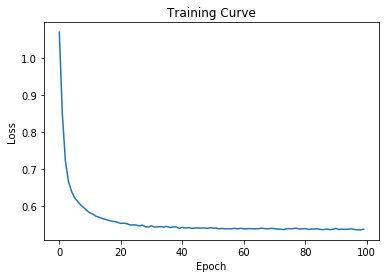

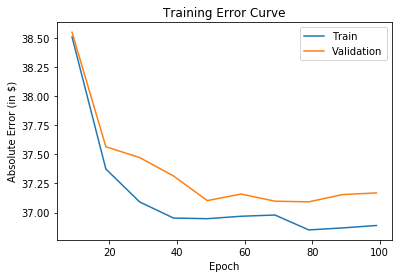

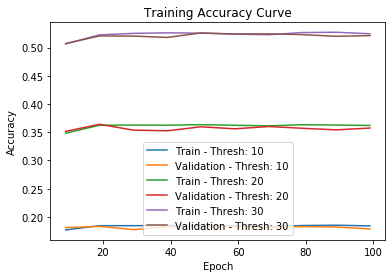

---[ITER 10] loss: 0.521902  time: 3.112
---[ITER 20] loss: 0.531788  time: 2.949
---[ITER 30] loss: 0.537902  time: 3.085
---[ITER 40] loss: 0.526094  time: 3.063
---[ITER 50] loss: 0.542693  time: 3.055
---[ITER 60] loss: 0.532718  time: 3.056
---[ITER 70] loss: 0.525370  time: 3.034
---[ITER 80] loss: 0.548213  time: 3.127
---[ITER 90] loss: 0.538456  time: 3.072
---[ITER 100] loss: 0.519166  time: 3.045
---[ITER 110] loss: 0.527909  time: 3.033
---[ITER 120] loss: 0.536012  time: 2.978
---[ITER 130] loss: 0.534910  time: 2.989
---[ITER 140] loss: 0.548038  time: 2.983
---[ITER 150] loss: 0.535644  time: 3.250
---[ITER 160] loss: 0.564540  time: 3.182
[EPOCH 101] loss: 0.535320  time: 51.501
---[ITER 10] loss: 0.535629  time: 3.121
---[ITER 20] loss: 0.546536  time: 3.327
---[ITER 30] loss: 0.535080  time: 2.991
---[ITER 40] loss: 0.531511  time: 2.999
---[ITER 50] loss: 0.534794  time: 3.088
---[ITER 60] loss: 0.526701  time: 3.030
---[ITER 70] loss: 0.531462  time: 3.056
---[ITER 

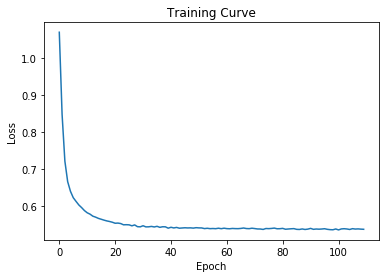

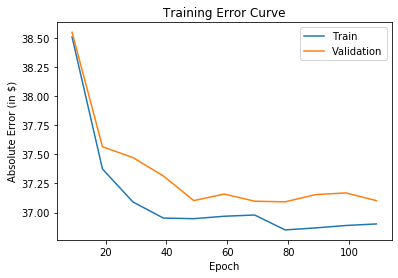

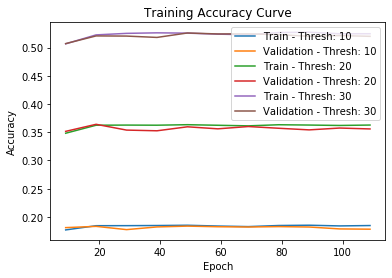

---[ITER 10] loss: 0.546450  time: 3.052
---[ITER 20] loss: 0.544895  time: 3.105
---[ITER 30] loss: 0.542588  time: 3.546
---[ITER 40] loss: 0.551793  time: 2.988
---[ITER 50] loss: 0.539894  time: 3.129
---[ITER 60] loss: 0.548989  time: 2.911
---[ITER 70] loss: 0.534886  time: 2.919
---[ITER 80] loss: 0.545650  time: 2.960
---[ITER 90] loss: 0.529224  time: 3.273
---[ITER 100] loss: 0.526134  time: 3.084
---[ITER 110] loss: 0.567881  time: 3.037
---[ITER 120] loss: 0.531554  time: 3.097
---[ITER 130] loss: 0.529376  time: 3.067
---[ITER 140] loss: 0.549816  time: 3.060
---[ITER 150] loss: 0.517164  time: 2.997
---[ITER 160] loss: 0.524793  time: 3.246
[EPOCH 111] loss: 0.539122  time: 51.778
---[ITER 10] loss: 0.546272  time: 3.225
---[ITER 20] loss: 0.552561  time: 3.008
---[ITER 30] loss: 0.528627  time: 2.861
---[ITER 40] loss: 0.530931  time: 2.875
---[ITER 50] loss: 0.536925  time: 2.927
---[ITER 60] loss: 0.531758  time: 3.113
---[ITER 70] loss: 0.533903  time: 2.976
---[ITER 

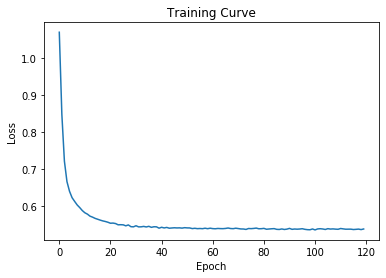

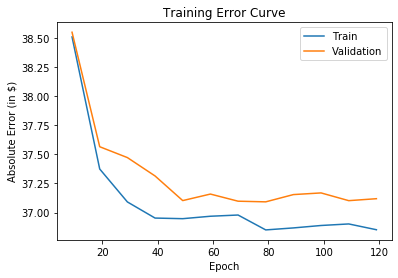

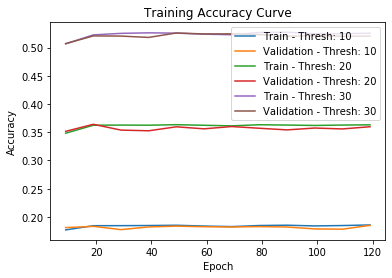

---[ITER 10] loss: 0.541339  time: 4.304
---[ITER 20] loss: 0.531857  time: 4.669
---[ITER 30] loss: 0.531646  time: 3.474
---[ITER 40] loss: 0.539529  time: 3.127
---[ITER 50] loss: 0.525850  time: 3.139
---[ITER 60] loss: 0.548691  time: 3.602
---[ITER 70] loss: 0.538810  time: 3.925
---[ITER 80] loss: 0.537700  time: 3.706
---[ITER 90] loss: 0.539697  time: 3.202
---[ITER 100] loss: 0.520019  time: 3.133
---[ITER 110] loss: 0.550659  time: 3.150
---[ITER 120] loss: 0.532412  time: 3.068
---[ITER 130] loss: 0.543005  time: 3.051
---[ITER 140] loss: 0.533877  time: 3.089
---[ITER 150] loss: 0.529582  time: 2.956
---[ITER 160] loss: 0.537999  time: 2.967
[EPOCH 121] loss: 0.537130  time: 56.883
---[ITER 10] loss: 0.515651  time: 2.940
---[ITER 20] loss: 0.541237  time: 3.121
---[ITER 30] loss: 0.549713  time: 3.839
---[ITER 40] loss: 0.528780  time: 4.399
---[ITER 50] loss: 0.542991  time: 4.106
---[ITER 60] loss: 0.551674  time: 3.593
---[ITER 70] loss: 0.532647  time: 3.293
---[ITER 

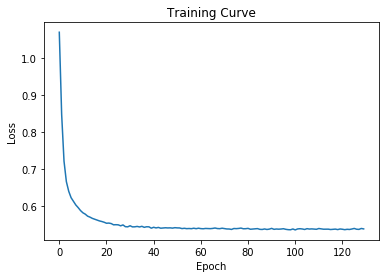

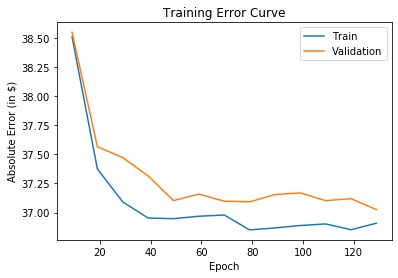

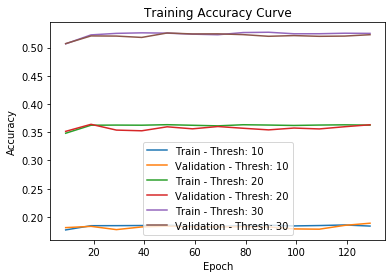

---[ITER 10] loss: 0.557394  time: 3.362
---[ITER 20] loss: 0.543248  time: 3.359
---[ITER 30] loss: 0.533980  time: 3.483
---[ITER 40] loss: 0.528869  time: 3.851
---[ITER 50] loss: 0.518586  time: 3.664
---[ITER 60] loss: 0.535228  time: 4.068
---[ITER 70] loss: 0.532062  time: 4.314
---[ITER 80] loss: 0.552553  time: 3.343
---[ITER 90] loss: 0.517772  time: 3.499
---[ITER 100] loss: 0.535373  time: 4.291
---[ITER 110] loss: 0.531872  time: 4.132
---[ITER 120] loss: 0.518959  time: 3.630
---[ITER 130] loss: 0.546000  time: 3.076
---[ITER 140] loss: 0.533911  time: 3.492
---[ITER 150] loss: 0.549380  time: 3.219
---[ITER 160] loss: 0.540099  time: 3.425
[EPOCH 131] loss: 0.536434  time: 60.749
---[ITER 10] loss: 0.532267  time: 3.105
---[ITER 20] loss: 0.526706  time: 3.140
---[ITER 30] loss: 0.534438  time: 3.157
---[ITER 40] loss: 0.547602  time: 3.097
---[ITER 50] loss: 0.533331  time: 3.043
---[ITER 60] loss: 0.539299  time: 3.361
---[ITER 70] loss: 0.545597  time: 3.000
---[ITER 

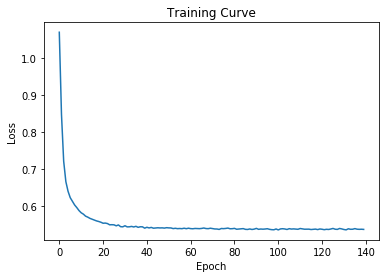

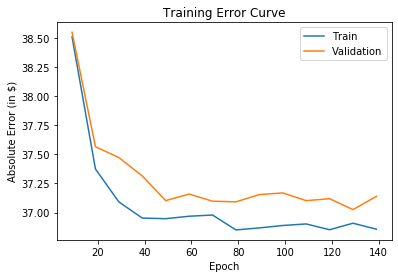

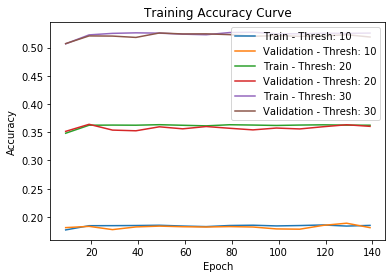

---[ITER 10] loss: 0.530203  time: 4.090
---[ITER 20] loss: 0.529198  time: 4.958
---[ITER 30] loss: 0.520543  time: 5.279
---[ITER 40] loss: 0.546367  time: 3.261
---[ITER 50] loss: 0.529809  time: 3.253
---[ITER 60] loss: 0.545228  time: 3.084
---[ITER 70] loss: 0.539820  time: 3.486
---[ITER 80] loss: 0.531099  time: 3.152
---[ITER 90] loss: 0.537425  time: 3.079
---[ITER 100] loss: 0.543398  time: 3.057
---[ITER 110] loss: 0.530834  time: 3.125
---[ITER 120] loss: 0.546795  time: 3.053
---[ITER 130] loss: 0.541574  time: 3.081
---[ITER 140] loss: 0.531892  time: 3.187
---[ITER 150] loss: 0.530762  time: 4.122
---[ITER 160] loss: 0.556076  time: 5.247
[EPOCH 141] loss: 0.535971  time: 61.522
---[ITER 10] loss: 0.541914  time: 3.563
---[ITER 20] loss: 0.529543  time: 4.835
---[ITER 30] loss: 0.538767  time: 4.457
---[ITER 40] loss: 0.522829  time: 3.708
---[ITER 50] loss: 0.550201  time: 3.316
---[ITER 60] loss: 0.536162  time: 3.200
---[ITER 70] loss: 0.536859  time: 3.898
---[ITER 

KeyboardInterrupt: 

In [23]:
net = airbnb_net()

path = os.getcwd() # get current path
path = path[:-5]+"test/Brian/"
now = datetime.datetime.now()
date = now.strftime("%b").lower()+now.strftime("%d")
i = 1

while True:
    try:
        rootdir = path+"/"+date+"_smalltest"+'{:02d}'.format(i)
        os.mkdir(rootdir)
        break
    except:
        i += 1
        
os.mkdir(rootdir+'/lossplot')
os.mkdir(rootdir+'/checkpoint')
os.mkdir(rootdir+'/accplot')
os.mkdir(rootdir+'/errorplot')
os.mkdir(rootdir+'/final')

torch.manual_seed(1)
train(net, train_loader, val_loader, rootdir, lr = 0.0001, num_epoch = 1000)

TESTING PARAMETERS:

nov17_smalltest01
- 14, 28, 28, 14, 1
- batch size 1000